# FDW Crop Production Data Profiling - Sudan and South Sudan

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:20135'
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/SD_Admin?_????.shp'))+\
            sorted(glob.glob('../data/shapefile/fewsnet/SS_Admin?_????.shp')) # search for both Sudan and South Sudan boundaries
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
#read in username and password
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': ['Sudan','South Sudan'],
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={}, auth=auth)
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #


- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1976	 | SD1976A1 | 18	| nan	| 0	| nan	| 0	|
| 1990	 | SD1990A1 | 26	| nan	| 0	| nan	| 0	|
| 2005	 | SD2005A1 | 25	| nan	| 0	| nan	| 0	|
| 2011	 | SD2011A1 | 15	| SD2011A2	| 133	| nan	| 0	|
| 2011	 | SD2011A1 | 15	| SS2011A2	| 79	| nan	| 0	|
| 2011	 | SS2011A1 | 10	| SD2011A2	| 133	| nan	| 0	|
| 2011	 | SS2011A1 | 10	| SS2011A2	| 79	| nan	| 0	|
| 2012	 | SD2012A1 | 17	| nan	| 0	| nan	| 0	|
| 2013	 | SD2013A1 | 18	| nan	| 0	| nan	| 0	|
| 2014	 | SD2014A1 | 18	| SD2014A2	| 172	| nan	| 0	|
----------------------------------------------- #


In [3]:
# In this cell we pull in the South Sudan shapefile to create continuous timeseries in the pre- and post- South Sudan period
#Merge South Sudan admins into the post-2011 Sudan admin files
SD_Admin1_2011 = SS_Admin1_2011.merge(SD_Admin1_2011,'outer')
SD_Admin1_2012 = SS_Admin1_2011.merge(SD_Admin1_2012,'outer') #South sudan has no new boundaries after 2011, so keep adding 2011
SD_Admin1_2013 = SS_Admin1_2011.merge(SD_Admin1_2013,'outer') 
SD_Admin1_2014 = SS_Admin1_2011.merge(SD_Admin1_2014,'outer')

#Matching happens on country later so we need to specify that we're creating time series that began with Sudan as the country
SD_Admin1_2011['COUNTRY'] = 'SD'; SD_Admin1_2011['ADMIN0'] = 'Sudan'
SD_Admin1_2012['COUNTRY'] = 'SD'; SD_Admin1_2012['ADMIN0'] = 'Sudan'
SD_Admin1_2013['COUNTRY'] = 'SD'; SD_Admin1_2013['ADMIN0'] = 'Sudan'
SD_Admin1_2014['COUNTRY'] = 'SD'; SD_Admin1_2014['ADMIN0'] = 'Sudan'

# Change the season name from "Main harvest" to "Main"
df['season_name'] = df['season_name'].replace('Main harvest', 'Main')

In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'

# Drop items at the country level (w/ FNID = 'SD')
df = df.loc[~(df.fnid=='SD')]

# Drop the IOM population group in South Sudan
df = df.loc[~(df['population_group'] ==  'Returnees (by IOM)')]

#Drop the blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]

#drop the admin 0 observations
df = df[~(df.fnid.astype(str).str[6:8]=='A0')]

#drop the admin 2 observations (by selecting for None type) because in there aren't enough to make a dataset from
df = df[df['admin_2'].isna()]

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([SD_Admin1_1976,SD_Admin1_1990,SD_Admin1_2005,SD_Admin1_2011,SS_Admin1_2011,SD_Admin1_2012,SD_Admin1_2013], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 17,031
Removed 4,976 "Missing Value" points
3,056/4,301 "Area Harvested" points are retained.
3,061/4,304 "Quantity Produced" points are retained.
3,063/4,309 "Yield" points are retained.
2,875/4,117 "Area Planted" points are retained.
Current data points: 12,055

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1975 - 2017
11 grain types are found: Cereal Crops (Mixed), Cotton (Acala), Cotton (American), Cotton (Egyptian), Groundnuts (In Shell), Millet, Pigeon Peas, Sesame Seed, Sorghum, Sunflower Seed, Wheat Grain
2 seasons are found: Main (10-01), Winter (04-01)
4 crop production system are found: none, irrigated, mechanized_rainfed, traditional_rainfed
Data sources include:
[1] FAO, WFP, Government of South Sudan (GoSS)  --- CFSAM special report, South Sudan
[2] Federal Ministry of Agriculture and Forestry (FMoA&F), Sudan --- Official agricultural

## Sudan and South Sudan
Sudan and South Sudan crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-sudan.png?itok=DRc-ECNF" width=900></br>

<img src="https://ipad.fas.usda.gov/countrysummary/images/SU/cropcalendar/eafrica_su_calendar.png" width=900>

- comparison of boundaries

<img src="../figures/SD_admin_shapes.png" width=900>

- In Sudan and South Sudan, basd on the FEWS NET data, there were six changes in administrative units, although they are mostly minor at the admin 1 level

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1976	 | SD1976A1 | 18	| nan	| 0	|
| 1990	 | SD1990A1 | 26	| nan	| 0	|
| 2005	 | SD2005A1 | 25	| nan	| 0	|
| 2011	 | SD2011A1 | 15	| SD2011A2	| 133	|
| 2012	 | SD2012A1 | 17	| nan	| 0	|
| 2013	 | SD2013A1 | 18	| nan	| 0	|


- Only wheat has two seasons (Main and Winter), and the vast majority of data is winter
- While there is a shapefile for 2014 and 2021, there is no crop data associated with either shapefile, so we use 2013 as the most recent shapefile

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = SD_Admin1_2013.copy().to_crs('epsg:20135')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

SD2011A115:	"Gezira" (FDW) is changed to "Jazirah" (shapefile).
SD2011A112:	"Gedaref" (FDW) is changed to "Qadarif" (shapefile).


In [6]:
# Link admin boundaries ------------------------- #
link_1976, over_1976 = FDW_PD_CreateAdminLink(SD_Admin1_1976, SD_Admin1_2013, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1990, over_1990 = FDW_PD_CreateAdminLink(SD_Admin1_1990, SD_Admin1_2013, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2005, over_2005 = FDW_PD_CreateAdminLink(SD_Admin1_2005, SD_Admin1_2013, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2011, over_2011 = FDW_PD_CreateAdminLink(SD_Admin1_2011, SD_Admin1_2013, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2012, over_2012 = FDW_PD_CreateAdminLink(SD_Admin1_2012, SD_Admin1_2013, 'ADMIN1', 'ADMIN1', prod, epsg)


# Crop specific ratios
link_ratio_1976 = FDW_PD_RatioAdminLink(link_1976, prod, over_1976, mdx_pss)
link_ratio_1990 = FDW_PD_RatioAdminLink(link_1990, prod, over_1990, mdx_pss)
link_ratio_2005 = FDW_PD_RatioAdminLink(link_2005, prod, over_2005, mdx_pss)
link_ratio_2011 = FDW_PD_RatioAdminLink(link_2011, prod, over_2011, mdx_pss)
link_ratio_2012 = FDW_PD_RatioAdminLink(link_2012, prod, over_2012, mdx_pss)


# Merge link_ratio
assert link_ratio_1976.keys() == link_ratio_2012.keys()
assert link_ratio_1990.keys() == link_ratio_2012.keys()
assert link_ratio_2005.keys() == link_ratio_2012.keys()
assert link_ratio_2011.keys() == link_ratio_2012.keys()

link_merged = [link_ratio_1976, link_ratio_1990, link_ratio_2005, 
               link_ratio_2011, link_ratio_2012]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [7]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "growing year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
#stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')


In [8]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Cereal Crops (Mixed)': 'Cereal Crops (Mixed)',
    'Cotton (Acala)': 'Cotton (Acala)',
    'Cotton (American)': 'Cotton (American)',
    'Cotton (Egyptian)': 'Cotton (Egyptian)',
    'Groundnuts (In Shell)': 'Groundnuts (In Shell)',
    'Millet': 'Millet',
    'Pigeon Peas': 'Pigeon Peas',
    'Sesame Seed': 'Sesame Seed',
    'Sorghum': 'Sorghum',
    'Sunflower Seed': 'Sunflower Seed',
    'Wheat Grain': 'Wheat'
 }
assert set(stack['product'].unique()) == set(product_category_custom.keys())
stack['product'] = stack['product'].replace(product_category_custom)
for f, r in link_ratio.items():
    mdx = pd.MultiIndex.from_frame(r.index.to_frame().reset_index(drop=True).replace(product_category_custom))
    r.index = mdx
    link_ratio[f] = r
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[(ecc['country'] == 'Sudan')|(ecc['country'] == 'South Sudan')]
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
stack_sd = stack[stack['country'] == 'Sudan'].reset_index(drop=True)
fn_out = '../data/crop/adm_crop_production_SD.csv'
stack_sd.to_csv(fn_out); print(f'{fn_out} is saved.')
stack_ss = stack[stack['country'] == 'South Sudan'].reset_index(drop=True)
fn_out = '../data/crop/adm_crop_production_SS.csv'
stack_ss.to_csv(fn_out); print(f'{fn_out} is saved.')

All [season_name, product, crop_production_system] are in the external crop calendar.
../data/crop/adm_crop_production_SD.csv is saved.
../data/crop/adm_crop_production_SS.csv is saved.


# Visualization of production data

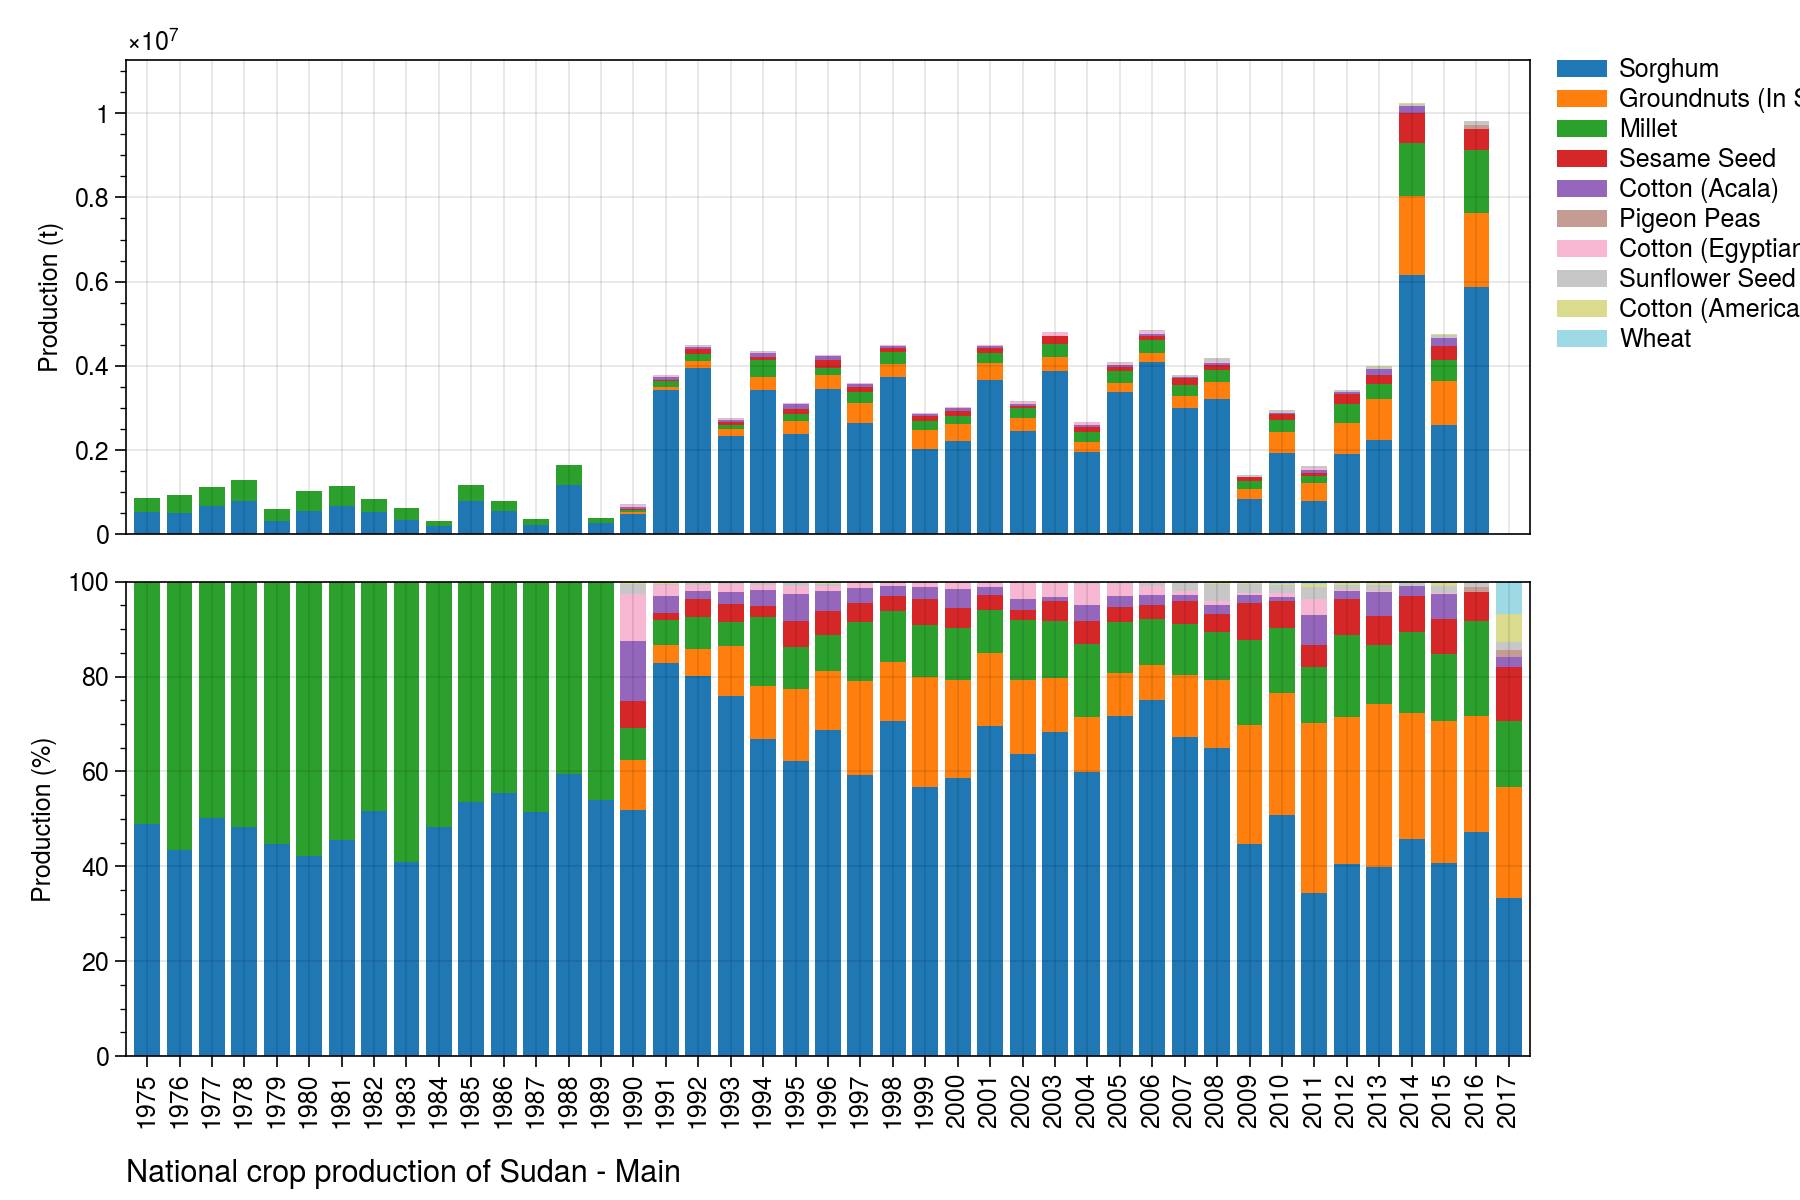

../figures/SD_bar_natgrainprod_Main.png is saved.


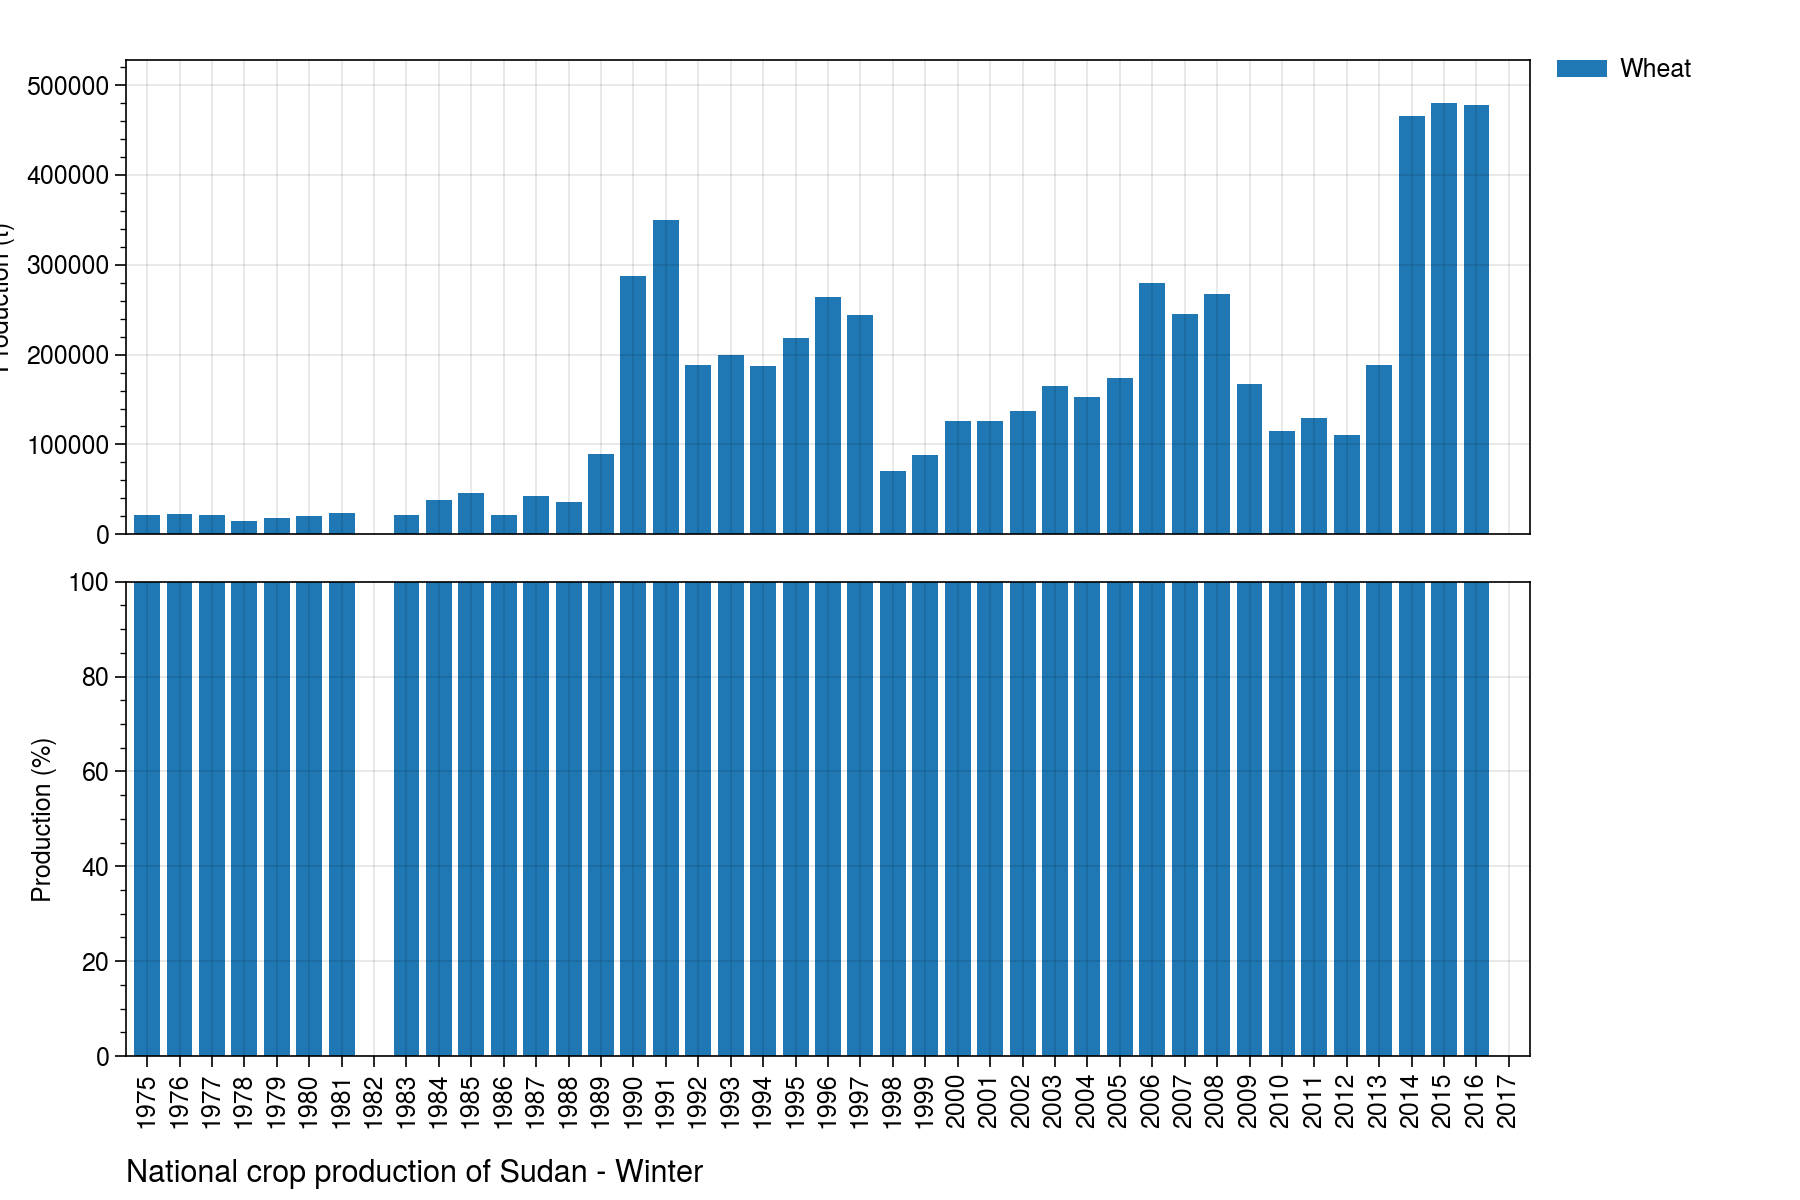

../figures/SD_bar_natgrainprod_Winter.png is saved.


In [9]:
# Bar chart of national crop production
country_iso, country_name = 'SD', 'Sudan'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main','Winter']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

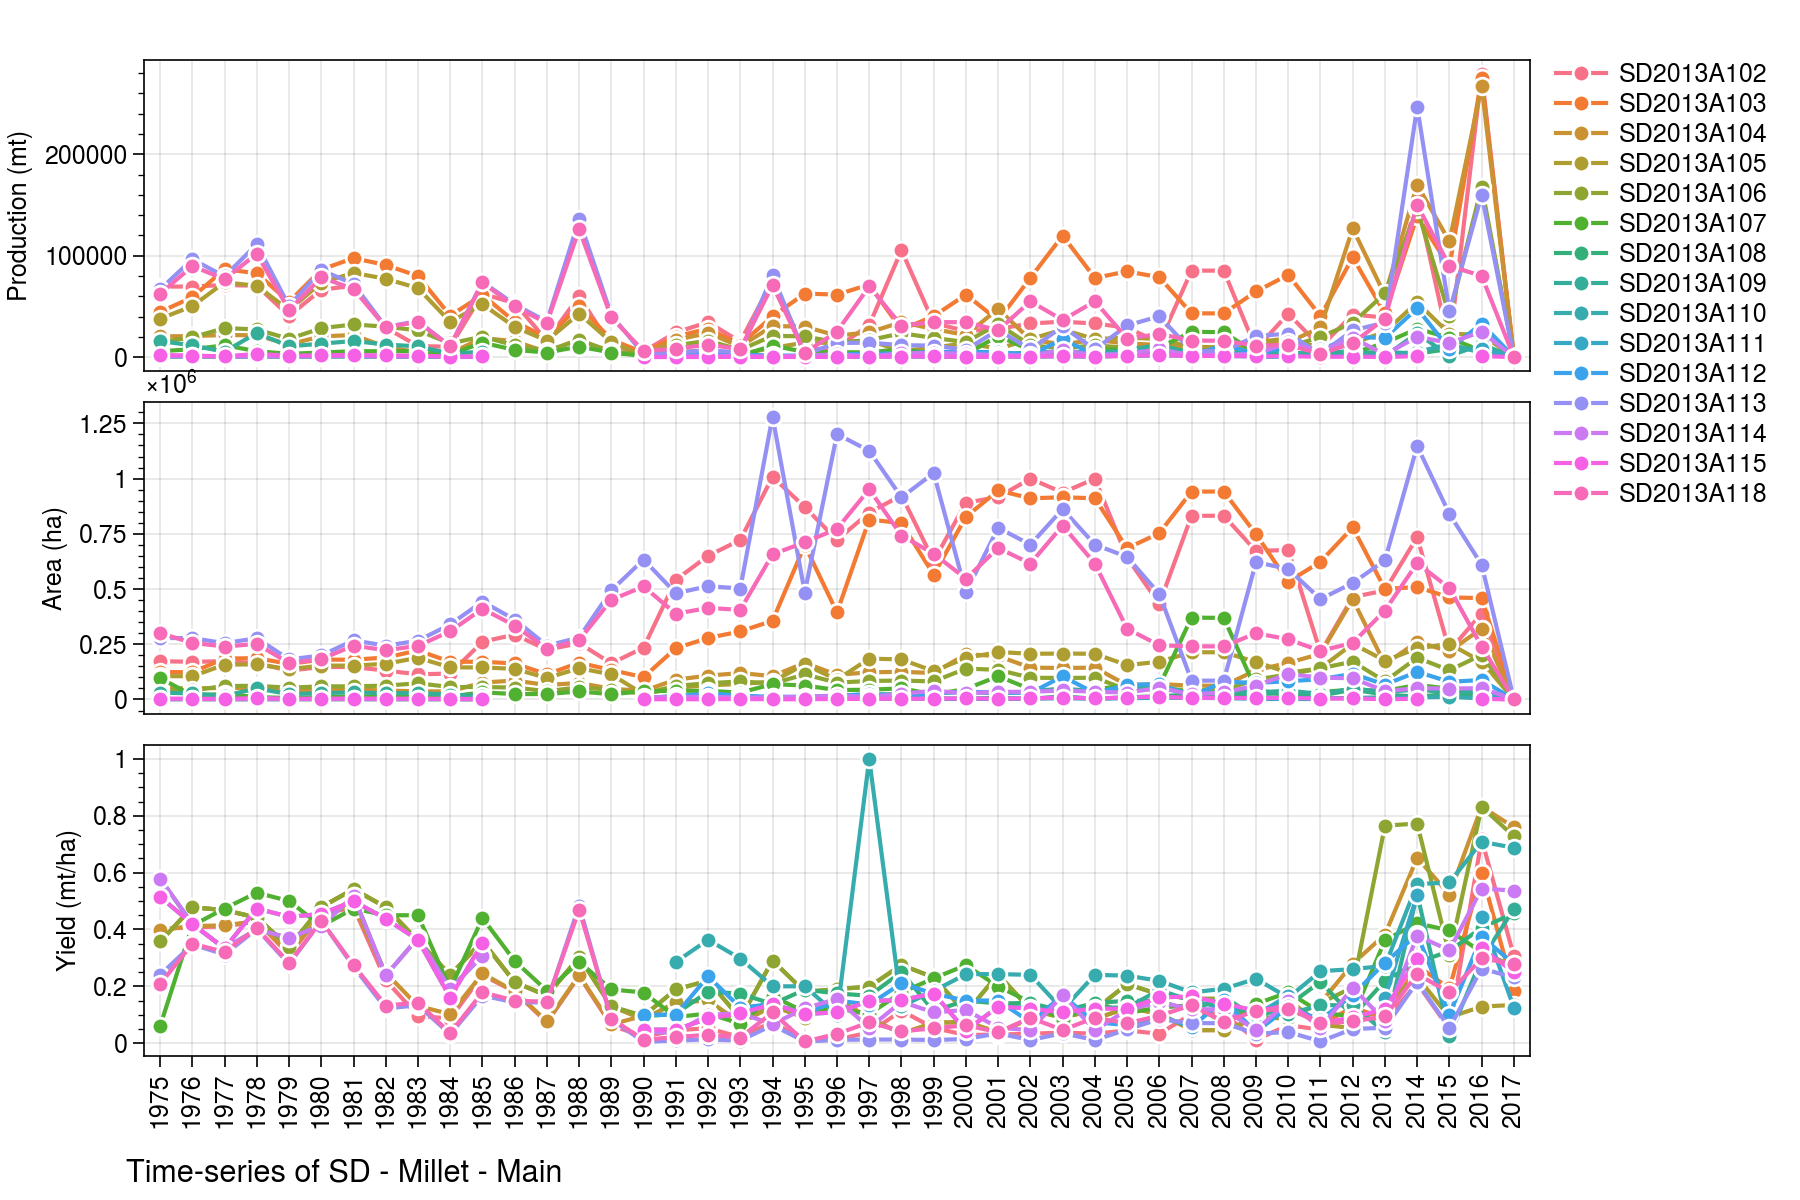

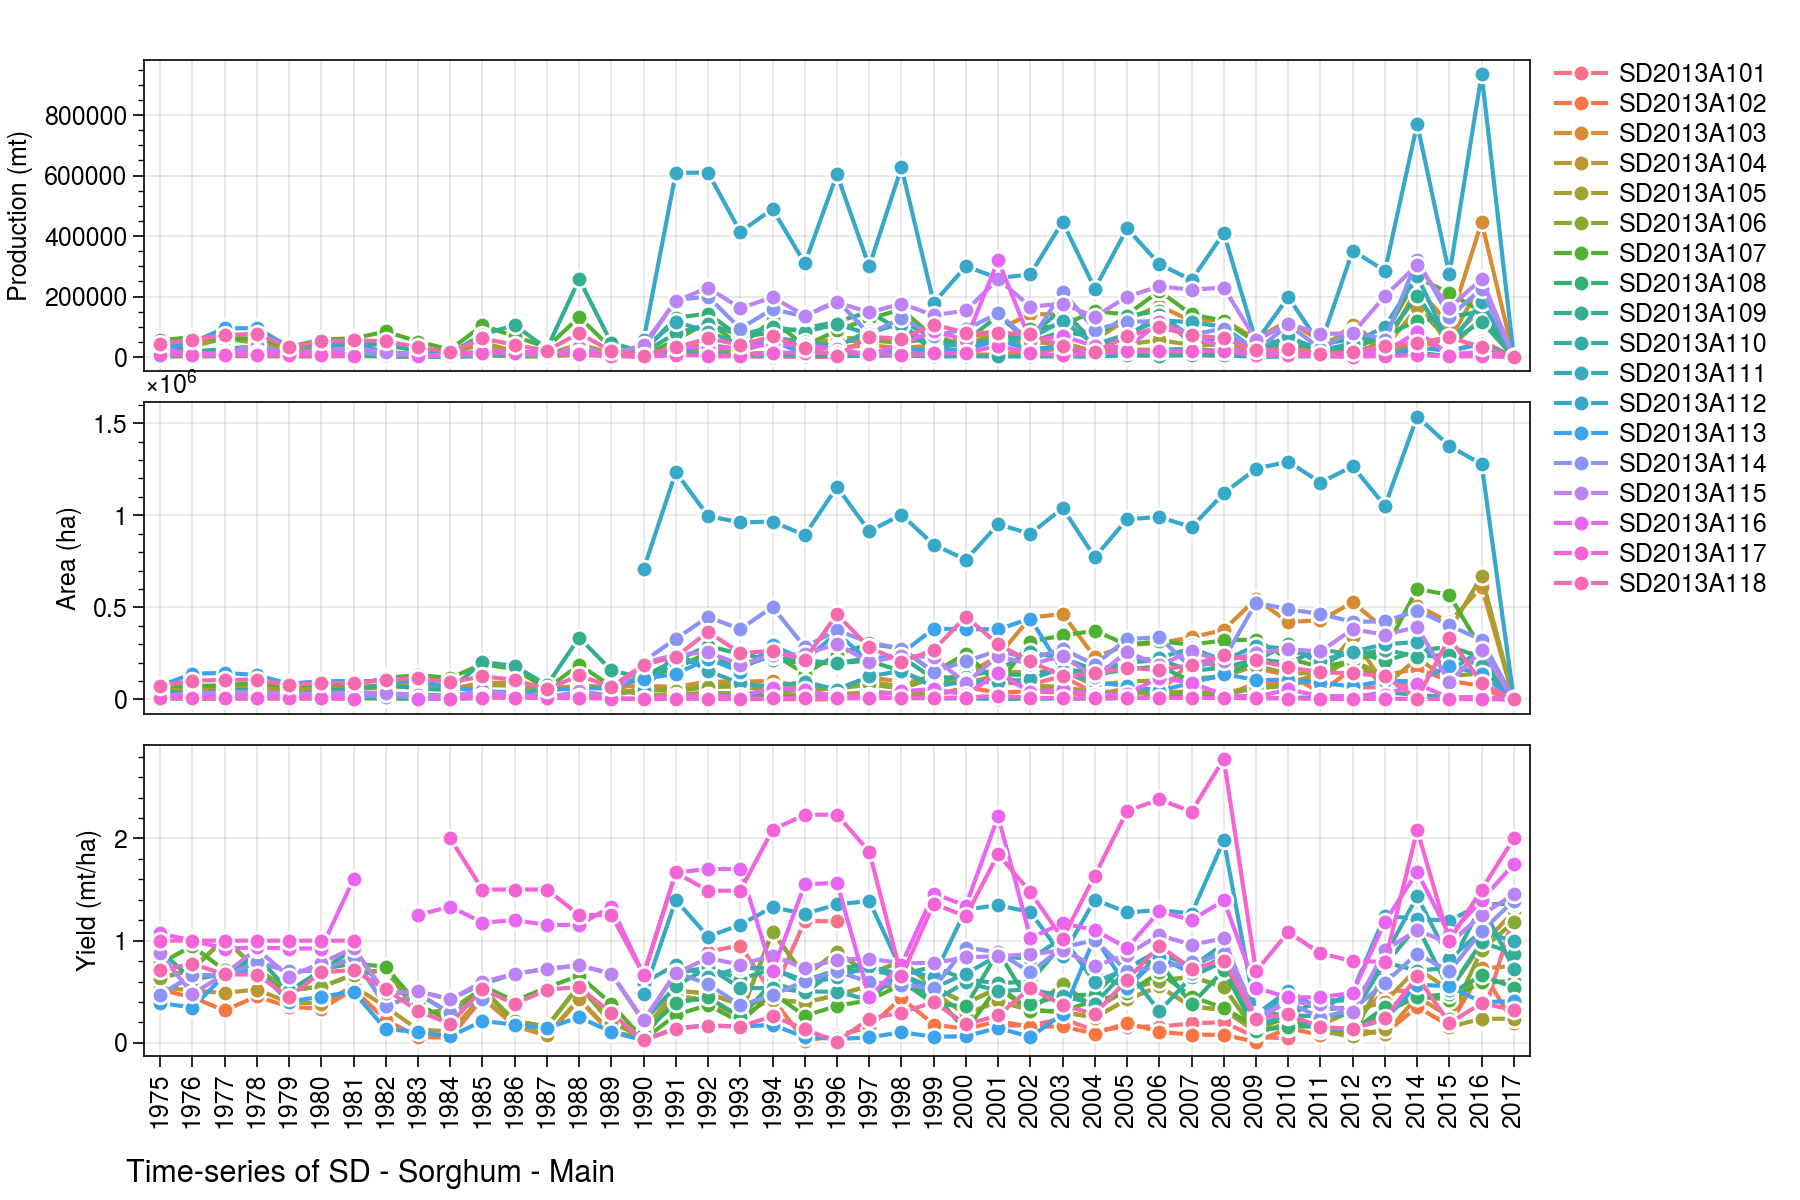

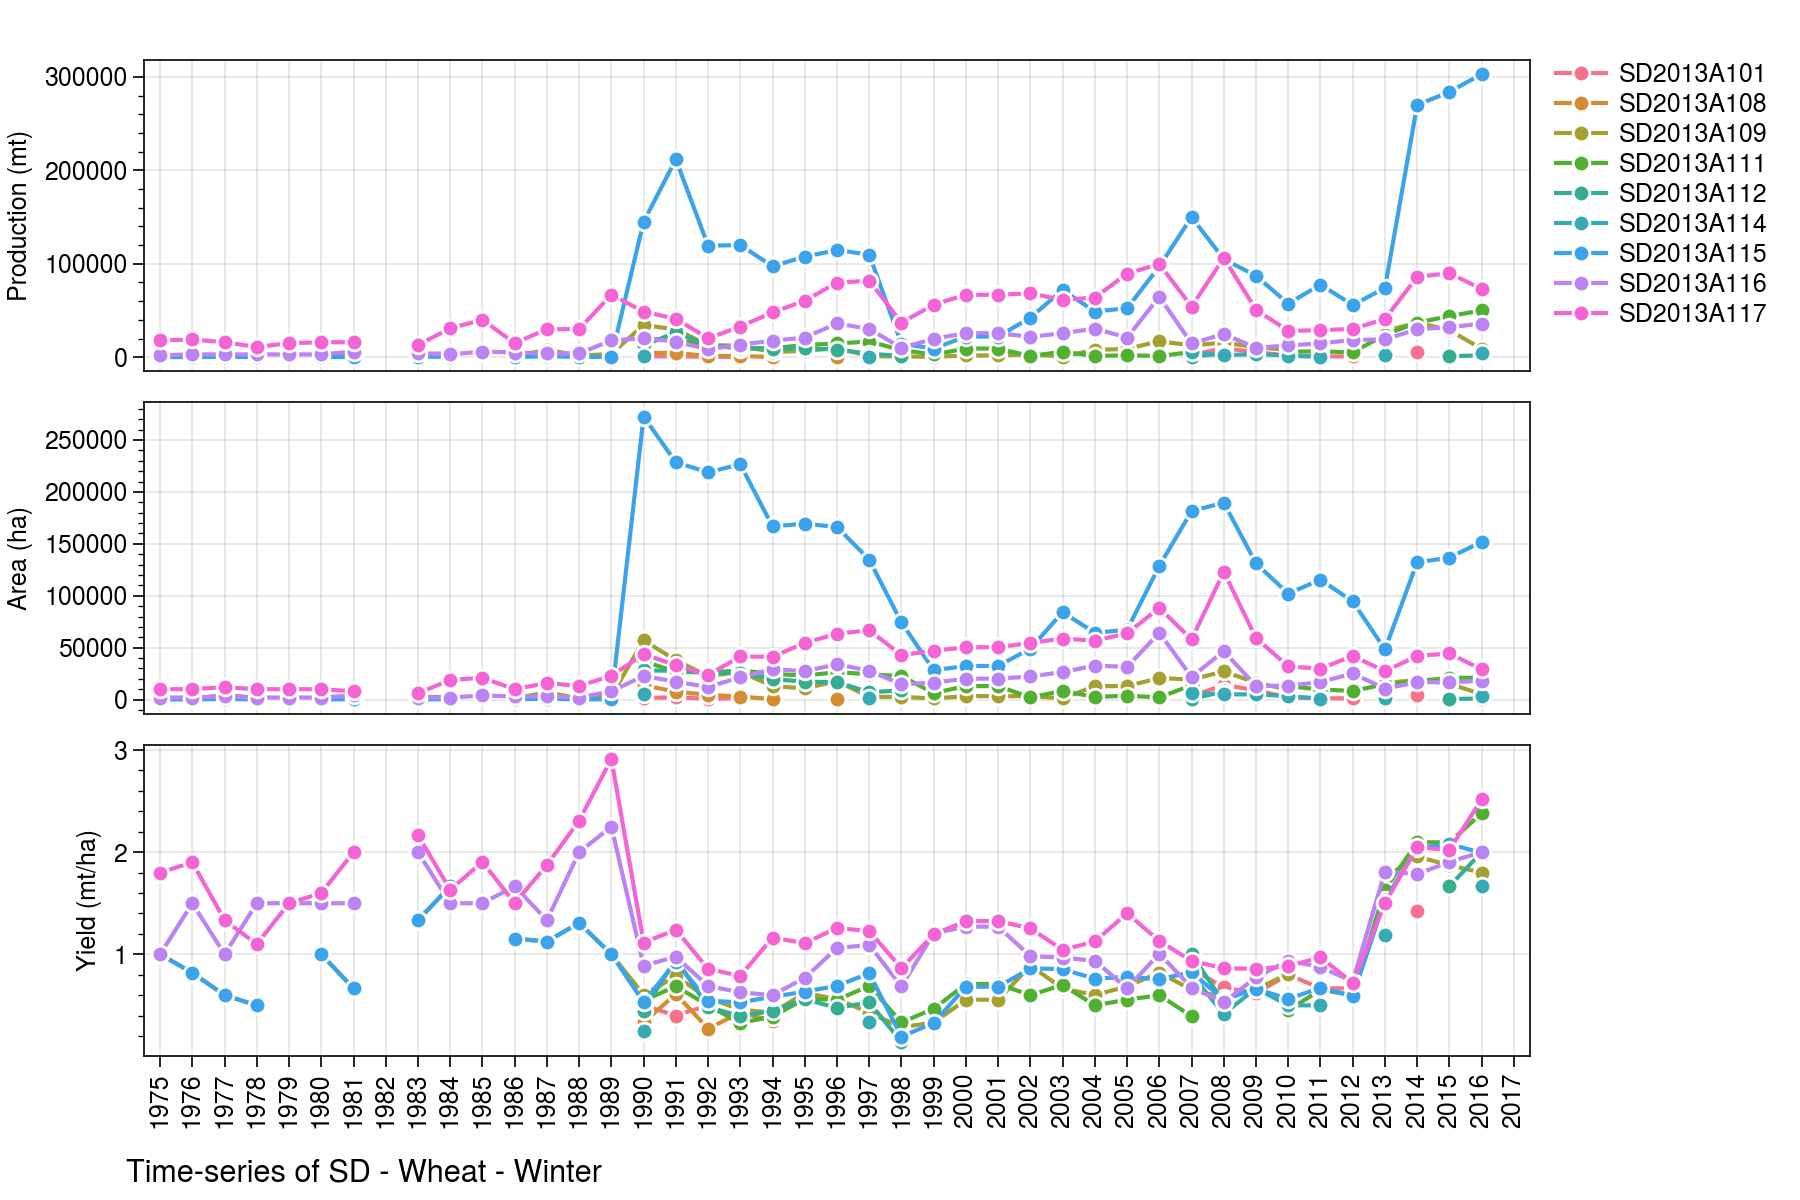

In [10]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name ='SD', 'Sudan'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Millet','Main'],
    ['Sorghum','Main'],
    ['Wheat','Winter'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)

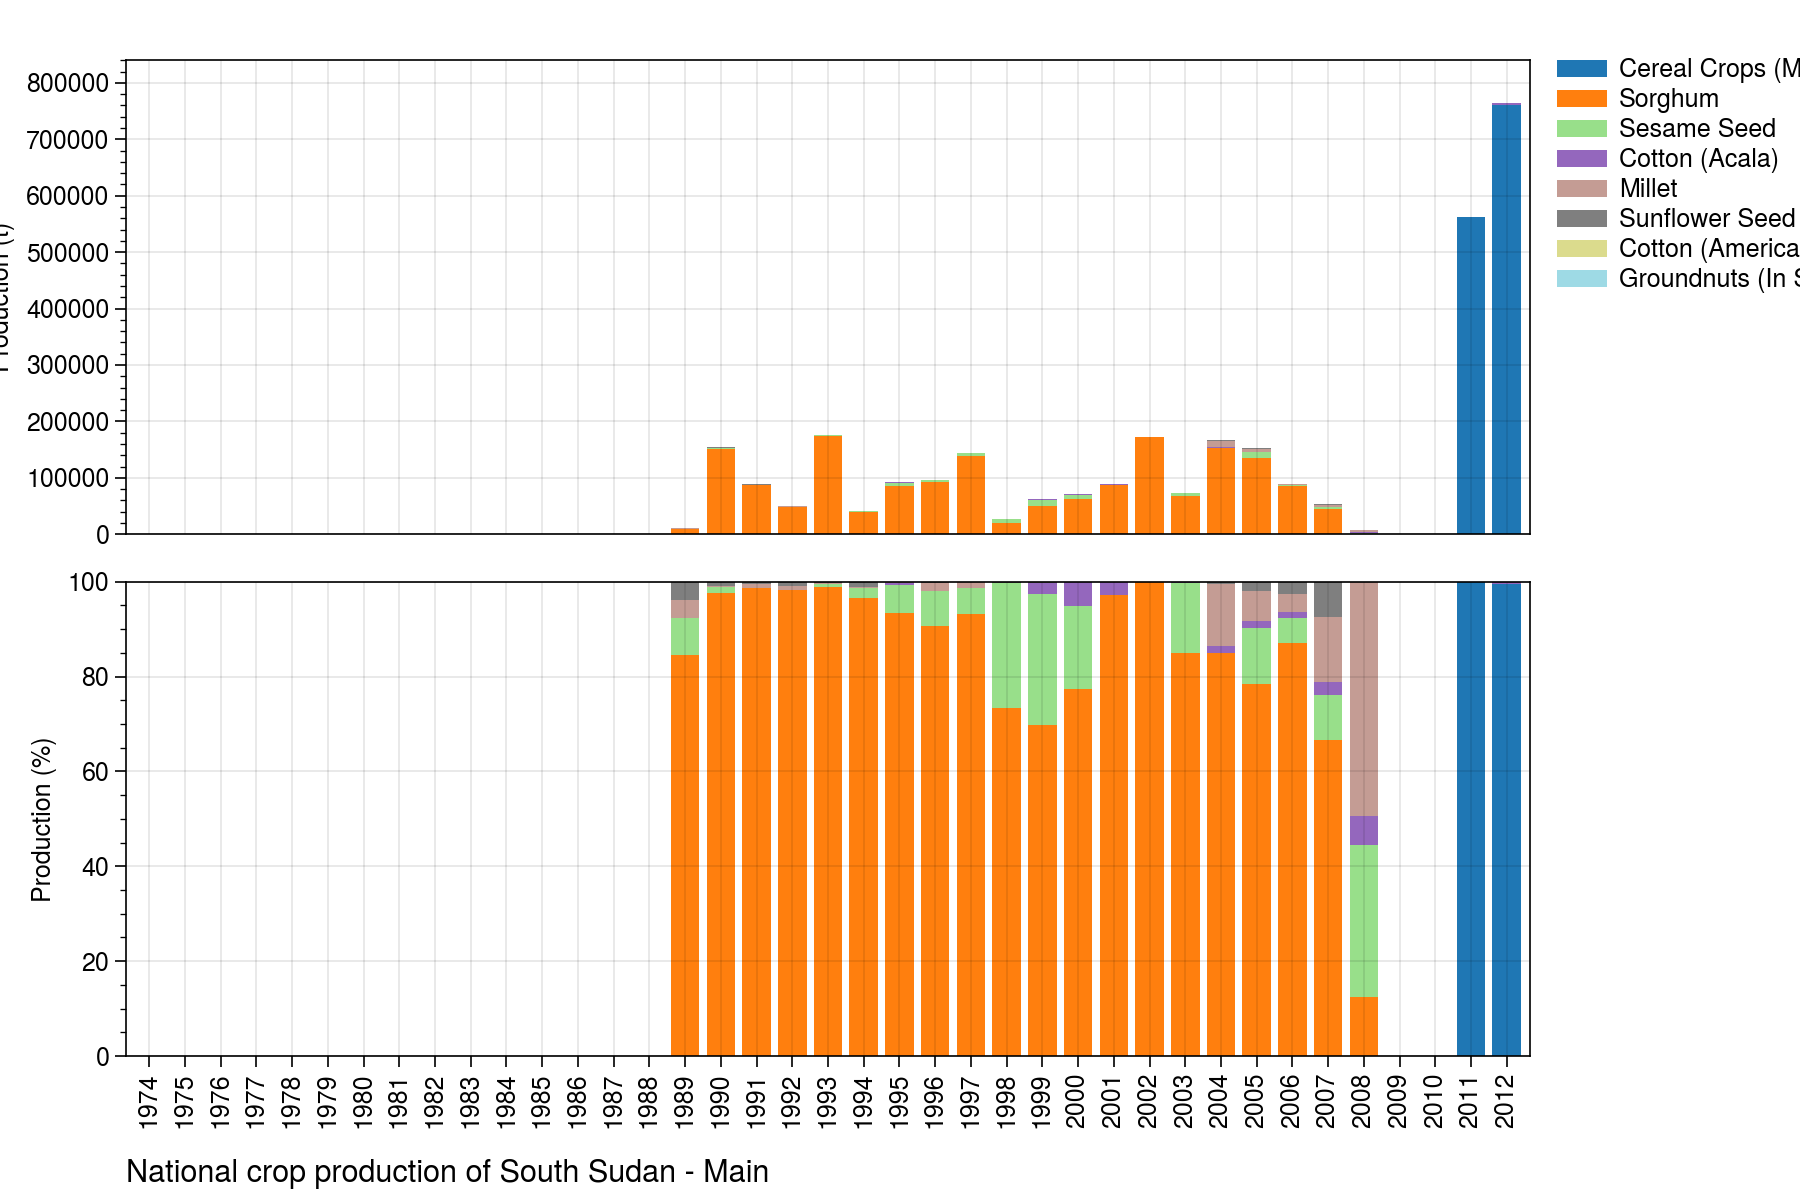

../figures/SS_bar_natgrainprod_Main.png is saved.


In [11]:
# Bar chart of national crop production
country_iso, country_name = 'SS', 'South Sudan'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

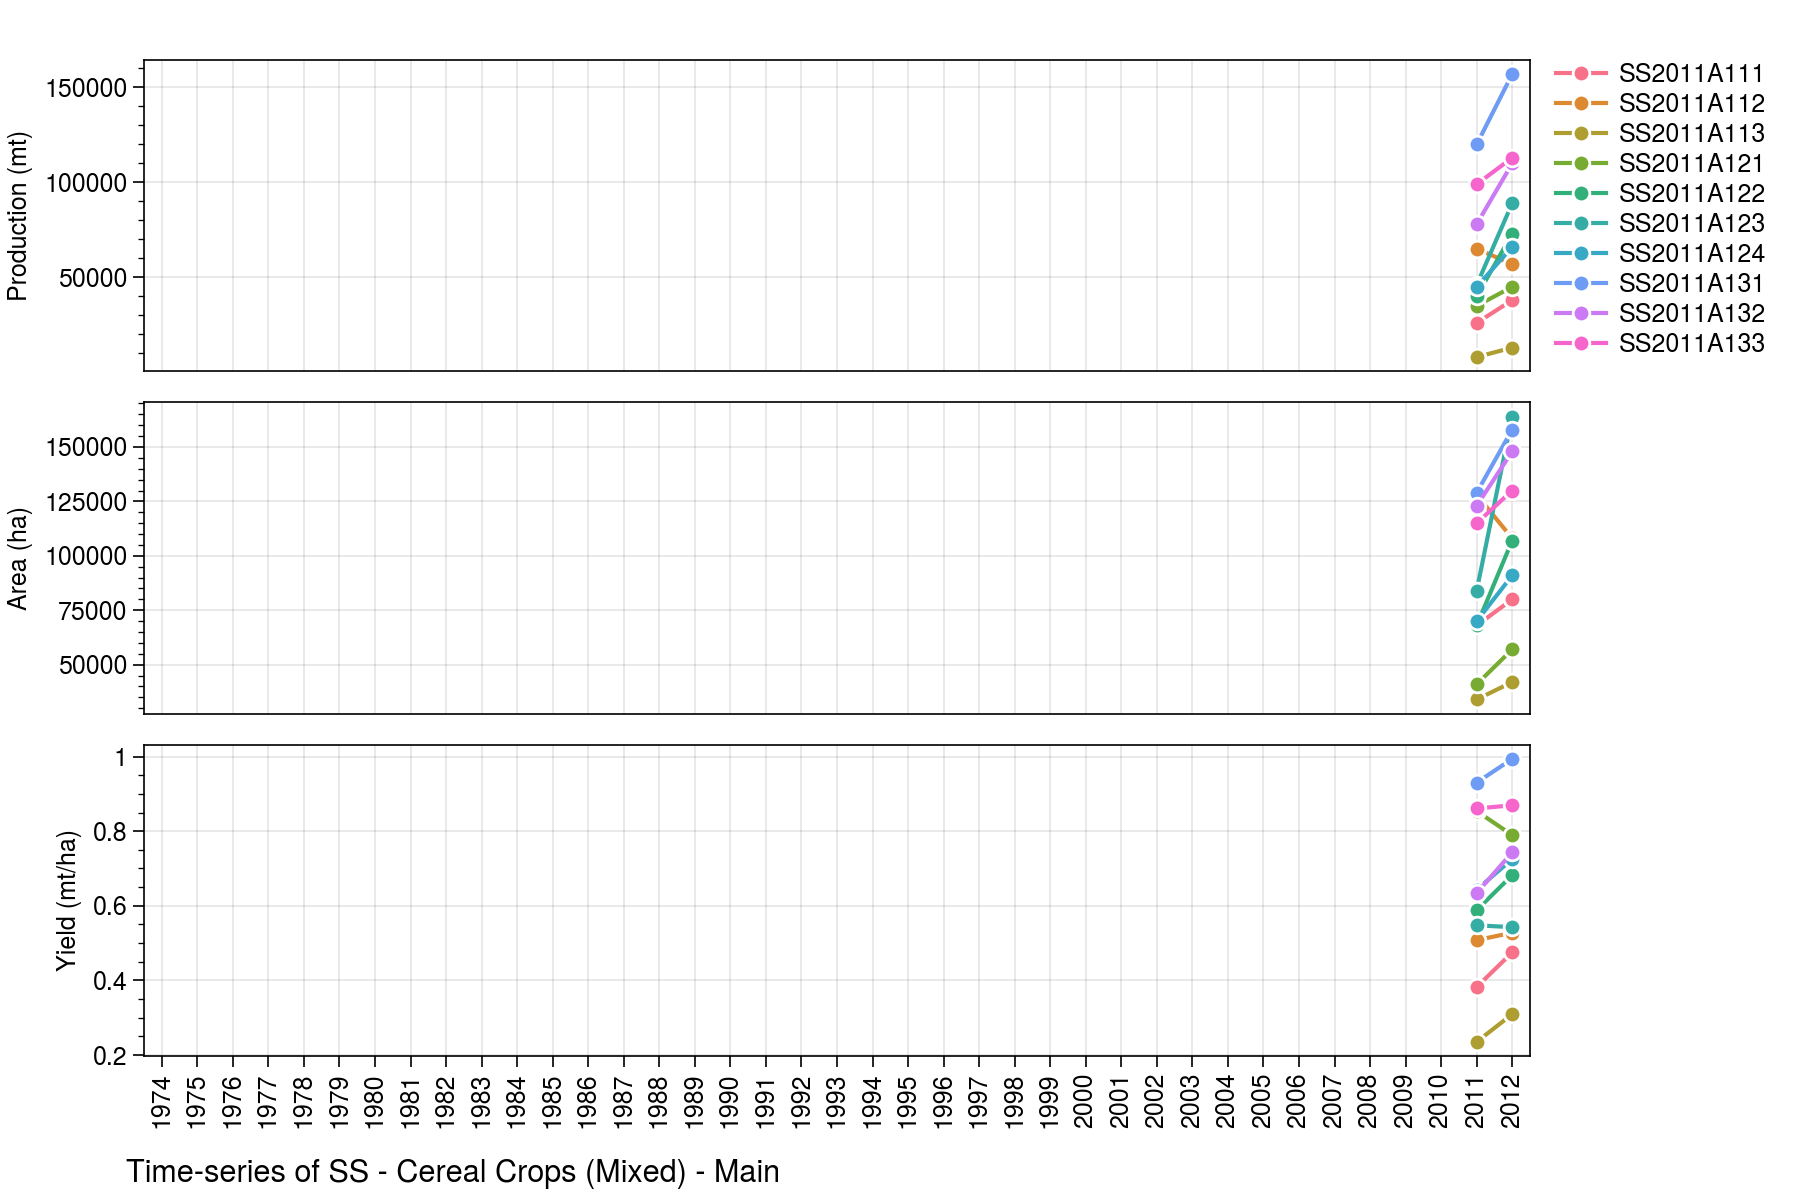

In [12]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'SS', 'South Sudan'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Cereal Crops (Mixed)','Main']
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)